### Try to reduce bias by selecting features to do imputation

In [1]:
import os
os.chdir("..")
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from utils.data import Dataset
from utils.data import create_adult_dataset, create_bank_dataset
from utils.data import create_communities_dataset, create_compas_dataset
from utils.data import create_german_dataset, create_titanic_dataset

In [3]:
from utils.generator import gen_complete_random
from utils.completer import complete_by_mean_col
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [4]:
def newBias(data, A=1, B=1):
    FPR_A = data[1] / (data[1] + data[0])
    FNR_A = data[2] / (data[2] + data[3])
    FPR_B  = data[5] / (data[5] + data[4])
    FNR_B  = data[6] / (data[6] + data[7])
    bias = A*abs(FPR_A - FPR_B) + B*abs(FNR_A - FNR_B)
    return bias

In [5]:
def cross_val(data_original: Dataset, data_config, clf_config, complete_function=None, selected_cols=[]):
    bias = []
    acc = []
    smote = SMOTE()
    scaler = StandardScaler()
    for i in range(10):
        if complete_function: data = gen_complete_random(data_original, random_ratio=0.4, selected_cols=selected_cols, print_all=False)
        else: data = data_original
        # print("Running Cross Validation {}".format(i))
        bias_cv = []
        acc_cv = []
        for train_idx, test_idx in StratifiedShuffleSplit(n_splits=20).split(data.X, data.y):
            X_train, X_test = data.X.iloc[train_idx].copy(), data.X.iloc[test_idx].copy()
            Y_train, Y_test = data.y[train_idx], data.y[test_idx]
            X_train.reset_index(drop=True, inplace=True)
            X_test.reset_index(drop=True, inplace=True)

            if complete_function:
                data_incomplete = Dataset("tmp", X_train, Y_train, types=data.types, 
                    protected_features=data.protected_features, categorical_features=data.categorical_features,
                    encoders=[data.X_encoders, data.y_encoder])
                try:
                    data_complete = complete_function(data_incomplete)
                except Exception as e:
                    print("Error: {}. Skipped".format(e))
                    continue
                if data_complete.X.isnull().sum().sum() > 0:
                    print("Complete function error, skipped")
                    continue
                X_train = data_complete.X.copy()
                Y_train = data_complete.y.copy()
            X_train.drop(columns=data.protected_features, inplace=True)

            if complete_function:
                data_incomplete = Dataset("tmp", X_test, Y_test, types=data.types, 
                    protected_features=data.protected_features, categorical_features=data.categorical_features,
                    encoders=[data.X_encoders, data.y_encoder])
                try:
                    data_complete = complete_function(data_incomplete)
                except Exception as e:
                    print("Error: {}. Skipped".format(e))
                    continue
                if data_complete.X.isnull().sum().sum() > 0:
                    print("Complete function error, skipped")
                    continue
                X_test = data_complete.X.copy()
                Y_test = data_complete.y.copy()
            
            X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)
            X_scaled = scaler.fit_transform(X_train_res)
            clf = LogisticRegression(max_iter=clf_config["max_iter"], C=clf_config["C"], tol=clf_config["tol"])
            clf.fit(X_scaled, Y_train_res)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop(columns=data.protected_features)), columns=X_test.drop(columns=data.protected_features).columns)
            X_test_scaled = pd.concat([X_test_scaled, X_test[data.protected_features]], axis=1)
            X_test_A = X_test_scaled[X_test_scaled[data_config["target"]] == data_config["A"]].drop(columns=data.protected_features).to_numpy()
            X_test_B = X_test_scaled[X_test_scaled[data_config["target"]] == data_config["B"]].drop(columns=data.protected_features).to_numpy()
            Y_test_A = Y_test[X_test_scaled[X_test_scaled[data_config["target"]] == data_config["A"]].index.tolist()]
            Y_test_B = Y_test[X_test_scaled[X_test_scaled[data_config["target"]] == data_config["B"]].index.tolist()]
            matrix_A = confusion_matrix(Y_test_A, clf.predict(X_test_A)).ravel().tolist()
            matrix_B = confusion_matrix(Y_test_B, clf.predict(X_test_B)).ravel().tolist()
            try:
                bias_cv.append(newBias(matrix_A+matrix_B))
            except Exception as e:
                print("\tError: {}, skipped".format(e))
            acc_cv.append(accuracy_score(clf.predict(X_test_scaled.drop(columns=data.protected_features).to_numpy()), Y_test))
        bias.append(np.mean(bias_cv))
        acc.append(np.mean(acc_cv))
    return (np.mean(bias), np.mean(acc))

In [6]:
def drop_na(data: Dataset) -> Dataset:
    data = data.copy()
    tmp_concat = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1)
    tmp_concat.dropna(inplace=True)
    tmp_concat.reset_index(drop=True, inplace=True)
    data.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
    data.y = tmp_concat["_TARGET_"].copy().to_numpy().ravel()
    return data

In [7]:
def run_experiment(data, data_config, clf_config, bias_threshold=0.05, missing_ratio=0.4):
    feature_selected = []
    acc_bias_pairs = []
    bias_acc_compare = cross_val(data.copy(), data_config, clf_config)
    all_features = data.X.columns.drop(data.protected_features).tolist()
    while len(feature_selected) < len(all_features):
        feature_to_search = list(set(feature_selected) ^ set(all_features))
        acc_bias_next = (-1, -1)
        next_feature = feature_to_search[0]
        for feature in feature_to_search:
            selected_cols = feature_selected + [feature]
            data_tmp = data.copy()
            bias, acc = cross_val(data_tmp, data_config, clf_config, complete_by_mean_col, selected_cols)
            if (acc_bias_next[0] < 0) or (bias < acc_bias_next[1]):
                acc_bias_next = (acc, bias)
                next_feature = feature
            print("\tImpute on features: {}, acc={:.2f}, bias={:.2f}".format(selected_cols, acc, bias))
        if (len(acc_bias_pairs) > 0) and (acc_bias_next[1] >= acc_bias_pairs[-1][1] + bias_threshold):
            print("Early Stopped")
            break
        print("Selected feature: {}".format(next_feature))
        feature_selected.append(next_feature)
        acc_bias_pairs.append(acc_bias_next)
    return feature_selected, acc_bias_pairs, bias_acc_compare

In [8]:
def plot_dataset(data_fn):
    with open("params_datasets.json", "r") as inFile:
        dataConfig = json.load(inFile)
    with open("params_acc.json", "r") as inFile:
        clfConfig = json.load(inFile)
    data = drop_na(data_fn())
    dataConfig = dataConfig[data.name]
    clfConfig = clfConfig[data.name]["LogReg"]
    print("Running on dataset: {}".format(data.name))
    feature_selected, acc_bias_pairs, bias_acc_compare = run_experiment(data, dataConfig, clfConfig)
    print("Features Selected:")
    for feature in feature_selected:
        print("\t{}".format(feature))
    plot_pos = np.arange(len(feature_selected)+1)
    bar_width = 0.3
    fig = plt.figure(figsize=(12, 8))
    ax_bias = fig.add_subplot(111)
    ax_acc = ax_bias.twinx()
    ax_bias.bar(plot_pos-bar_width/2, [bias_acc_compare[0]] + [m[1] for m in acc_bias_pairs], width=bar_width, label="Bias", color="Orange")
    ax_acc.bar(plot_pos+bar_width/2, [bias_acc_compare[1]] + [m[0] for m in acc_bias_pairs], width=bar_width, label="Accuracy", color="Blue")
    ax_bias.set_xticks(plot_pos)
    ax_bias.set_xlabel("Features Selected")
    ax_bias.set_ylabel("Bias")
    ax_acc.set_ylabel("Accuracy")
    ax_bias.legend(loc="upper left")
    ax_acc.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

Running on dataset: titanic
	Impute on features: ['Embarked'], acc=0.69, bias=0.32
	Impute on features: ['Pclass'], acc=0.64, bias=0.35
	Impute on features: ['Fare'], acc=0.70, bias=0.33
	Impute on features: ['Age'], acc=0.69, bias=0.35
	Impute on features: ['Parch'], acc=0.69, bias=0.34
	Impute on features: ['SibSp'], acc=0.68, bias=0.35
Selected feature: Embarked
	Impute on features: ['Embarked', 'Pclass'], acc=0.65, bias=0.31
	Impute on features: ['Embarked', 'Fare'], acc=0.70, bias=0.35
	Impute on features: ['Embarked', 'Age'], acc=0.69, bias=0.33
	Impute on features: ['Embarked', 'Parch'], acc=0.70, bias=0.32
	Impute on features: ['Embarked', 'SibSp'], acc=0.69, bias=0.35
Selected feature: Pclass
	Impute on features: ['Embarked', 'Pclass', 'Fare'], acc=0.65, bias=0.35
	Impute on features: ['Embarked', 'Pclass', 'Age'], acc=0.66, bias=0.34
	Impute on features: ['Embarked', 'Pclass', 'Parch'], acc=0.66, bias=0.32
	Error: division by zero, skipped
	Impute on features: ['Embarked', 'P

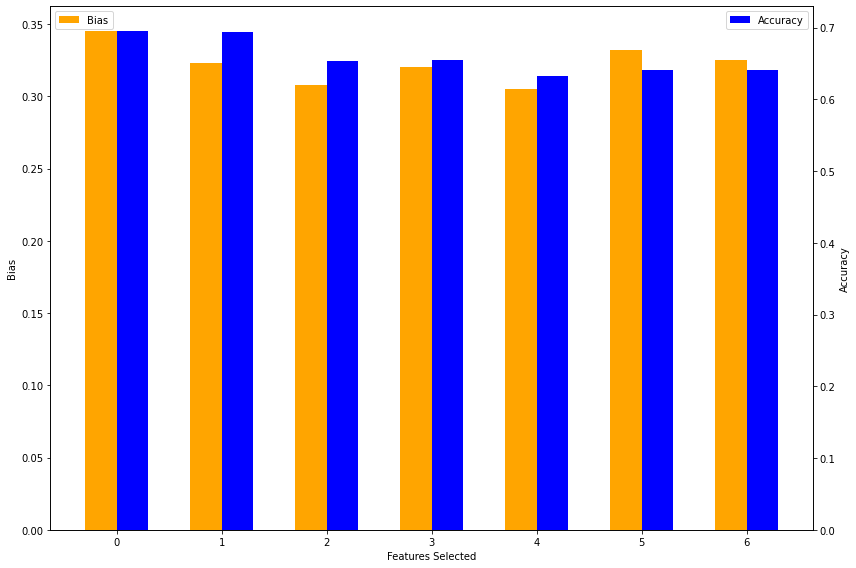

In [9]:
plot_dataset(create_titanic_dataset)

Running on dataset: compas
	Impute on features: ['age'], acc=0.65, bias=0.39
	Impute on features: ['juv_fel_count'], acc=0.64, bias=0.43
	Impute on features: ['priors_count'], acc=0.61, bias=0.39
	Impute on features: ['juv_other_count'], acc=0.64, bias=0.43
	Impute on features: ['sex'], acc=0.64, bias=0.43
	Impute on features: ['days_b_screening_arrest'], acc=0.64, bias=0.43
	Impute on features: ['juv_misd_count'], acc=0.64, bias=0.42
	Impute on features: ['age_cat'], acc=0.63, bias=0.43
	Impute on features: ['length_of_stay'], acc=0.65, bias=0.46
	Impute on features: ['c_charge_degree'], acc=0.65, bias=0.46
Selected feature: priors_count
	Impute on features: ['priors_count', 'age'], acc=0.60, bias=0.33
	Impute on features: ['priors_count', 'juv_fel_count'], acc=0.61, bias=0.37
	Impute on features: ['priors_count', 'juv_other_count'], acc=0.61, bias=0.38
	Impute on features: ['priors_count', 'sex'], acc=0.61, bias=0.38
	Impute on features: ['priors_count', 'days_b_screening_arrest'], a

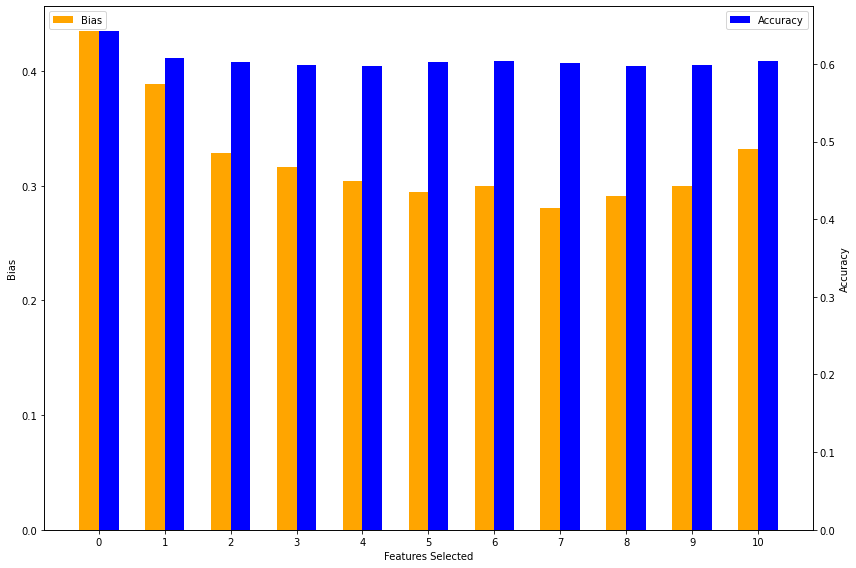

In [10]:
plot_dataset(create_compas_dataset)

Running on dataset: german
	Impute on features: ['Job'], acc=0.74, bias=0.36
	Impute on features: ['Residence_since'], acc=0.74, bias=0.36
	Impute on features: ['Telephone'], acc=0.74, bias=0.37
	Impute on features: ['Housing'], acc=0.74, bias=0.35
	Impute on features: ['Status_account'], acc=0.73, bias=0.38
	Impute on features: ['Savings_account'], acc=0.74, bias=0.37
	Impute on features: ['Credit_amount'], acc=0.75, bias=0.38
	Impute on features: ['Personal_status'], acc=0.73, bias=0.38
	Impute on features: ['Debtors_guarantors'], acc=0.74, bias=0.35
	Impute on features: ['Purpose'], acc=0.74, bias=0.37
	Impute on features: ['Employment_since'], acc=0.74, bias=0.37
	Impute on features: ['Duration_month'], acc=0.73, bias=0.36
	Impute on features: ['Installment_rate'], acc=0.74, bias=0.36
	Impute on features: ['Property'], acc=0.74, bias=0.36
	Impute on features: ['Number_credits'], acc=0.75, bias=0.33
	Impute on features: ['Foreign'], acc=0.75, bias=0.36
	Impute on features: ['Credit_

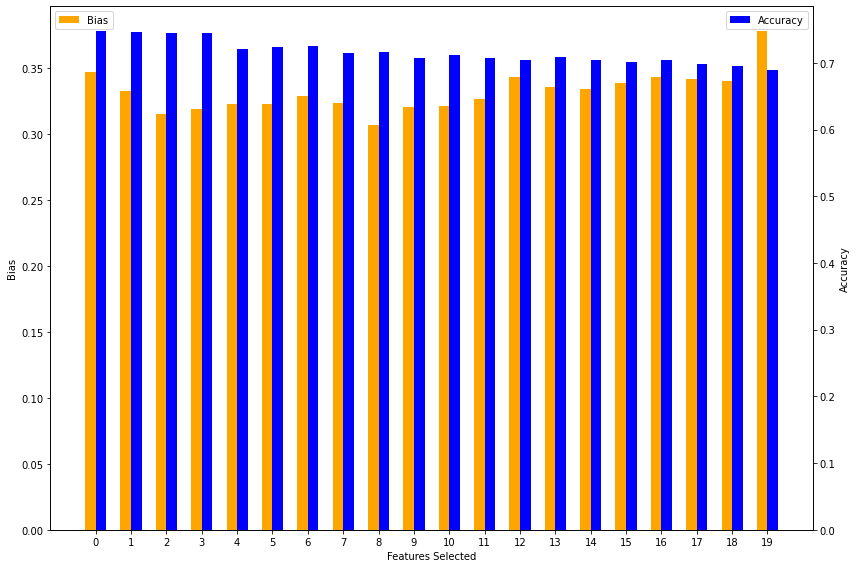

In [11]:
plot_dataset(create_german_dataset)

Running on dataset: adult
	Impute on features: ['education'], acc=0.73, bias=0.61
	Impute on features: ['age'], acc=0.72, bias=0.63
	Impute on features: ['marital-status'], acc=0.73, bias=0.61
	Impute on features: ['education-num'], acc=0.70, bias=0.77
	Impute on features: ['occupation'], acc=0.73, bias=0.61
	Impute on features: ['relationship'], acc=0.73, bias=0.48
	Impute on features: ['race'], acc=0.73, bias=0.61
	Impute on features: ['hours-per-week'], acc=0.73, bias=0.60
	Impute on features: ['workclass'], acc=0.73, bias=0.61
Selected feature: relationship
	Impute on features: ['relationship', 'education'], acc=0.73, bias=0.47
	Impute on features: ['relationship', 'age'], acc=0.72, bias=0.46
	Impute on features: ['relationship', 'marital-status'], acc=0.73, bias=0.47
	Impute on features: ['relationship', 'education-num'], acc=0.70, bias=0.60
	Impute on features: ['relationship', 'occupation'], acc=0.73, bias=0.47
	Impute on features: ['relationship', 'race'], acc=0.73, bias=0.47
	

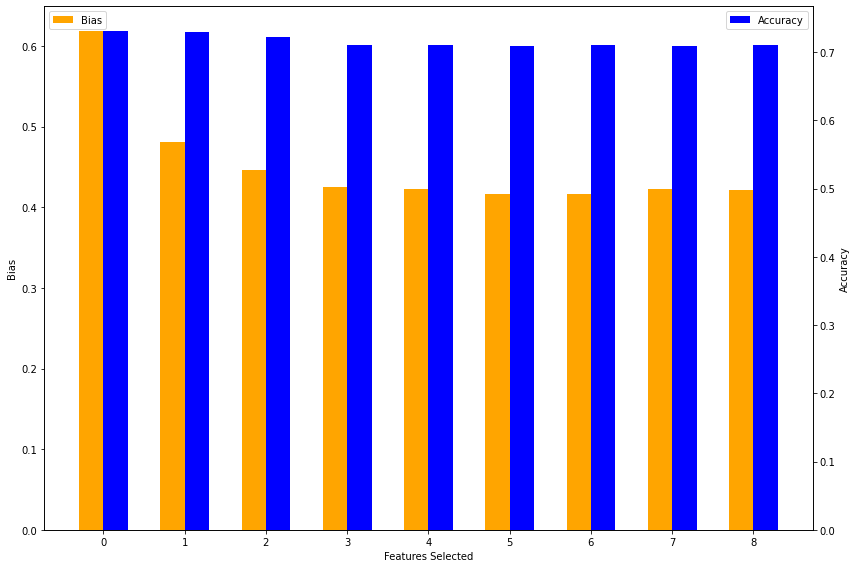

In [12]:
plot_dataset(create_adult_dataset)

Running on dataset: bank
	Impute on features: ['default'], acc=0.81, bias=0.11
	Impute on features: ['education'], acc=0.81, bias=0.11
	Impute on features: ['previous'], acc=0.81, bias=0.12
	Impute on features: ['poutcome'], acc=0.82, bias=0.11
	Impute on features: ['day'], acc=0.81, bias=0.12
	Impute on features: ['duration'], acc=0.77, bias=0.11
	Impute on features: ['month'], acc=0.81, bias=0.12
	Impute on features: ['job'], acc=0.81, bias=0.12
	Impute on features: ['housing'], acc=0.79, bias=0.11
	Impute on features: ['loan'], acc=0.81, bias=0.12
	Impute on features: ['contact'], acc=0.81, bias=0.15
	Impute on features: ['pdays'], acc=0.82, bias=0.11
	Impute on features: ['balance'], acc=0.81, bias=0.12
	Impute on features: ['campaign'], acc=0.81, bias=0.12
	Impute on features: ['marital'], acc=0.81, bias=0.11
Selected feature: housing
	Impute on features: ['housing', 'default'], acc=0.79, bias=0.12
	Impute on features: ['housing', 'education'], acc=0.79, bias=0.12
	Impute on featu

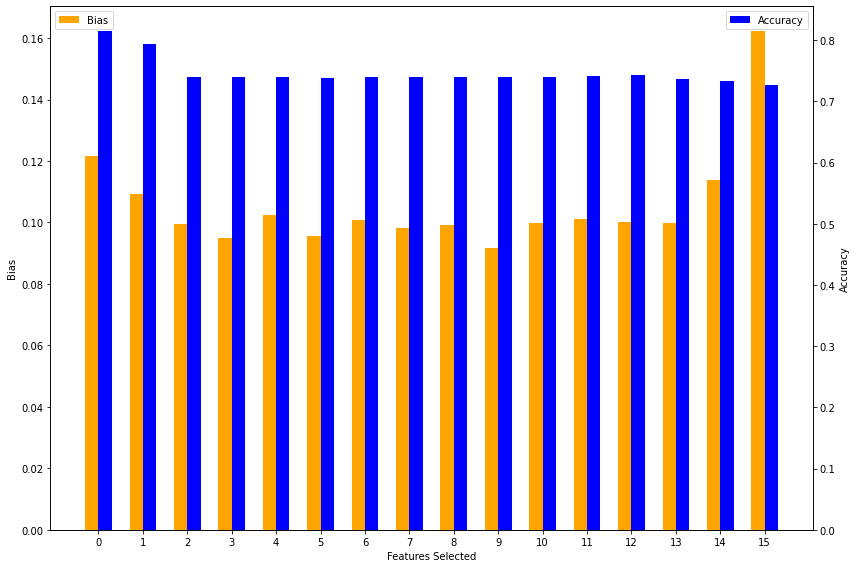

In [13]:
plot_dataset(create_bank_dataset)